# Initial Analysis of ITC Prompt

## Important Takeaways from Prompt:

- 4th highest annual ridership for commuter rail outside of Amtrak's Northeast Corridor.
- 20% bicylce mode share ([1% national average for reference](https://bikeleague.org/wp-content/uploads/bfareportcards/bfs/2017/california.pdf))
  - Should probably focus on either adding or working with existing biking infrastructure
- 4 million annual bus ridership (Unitrans)

In [6]:
# Load in directories
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon

from utils import plot_crashes_by_category, ll_to_xy, radius_label

## Traffic Analysis

The first segment of this notebook will be on crash analysis. This includes loading in data from TIMS and seeing what crashes occured in our **Area of Interest (AOI)** based on the main project prompt. Since a lot of the times the AOI doesn't give a full look on the incidents in the area, we will look slightly around the area as well (0.5-2 mile radius search).

Then we will analyze the type of crashes that occured to influence future designs / plans.

In [7]:
### Davis Jurisdictional Boundaries ###
davis_gdf = gpd.read_file("data/Yolo_County_Open_Data_Street_Centerlines_-2417930449303182445.geojson")
if davis_gdf.crs != "EPSG:4326":
    davis_gdf = davis_gdf.to_crs(4326)
    
#### Crashes Data (GIS & Qualative / Quantative) ###
crash_data = pd.read_csv("data/davis_crashes.csv")
crash_gdf = gpd.GeoDataFrame(
    crash_data,
    geometry=gpd.points_from_xy(crash_data["LONGITUDE"], crash_data["LATITUDE"]),
    crs="EPSG:4326"
)

### Area of Interest for Project Prompt ###
# this is copy & pasted from Lat-Lon format in Google Maps
top_left     = (38.543680985703226, -121.7440795432951)
top_right    = (38.545050789861584, -121.73714115854816)
bottom_right = (38.54333958192836,  -121.73654298866767)
bottom_left  = (38.54217103842081,  -121.74365700939322)

# Convert (lat, lon) → (lon, lat)
aoi_poly_ll = Polygon([
    ll_to_xy(top_left),
    ll_to_xy(top_right),
    ll_to_xy(bottom_right),
    ll_to_xy(bottom_left),
    ll_to_xy(top_left)
])

aoi = gpd.GeoDataFrame(geometry=[aoi_poly_ll], crs="EPSG:4326").to_crs("EPSG:3310")

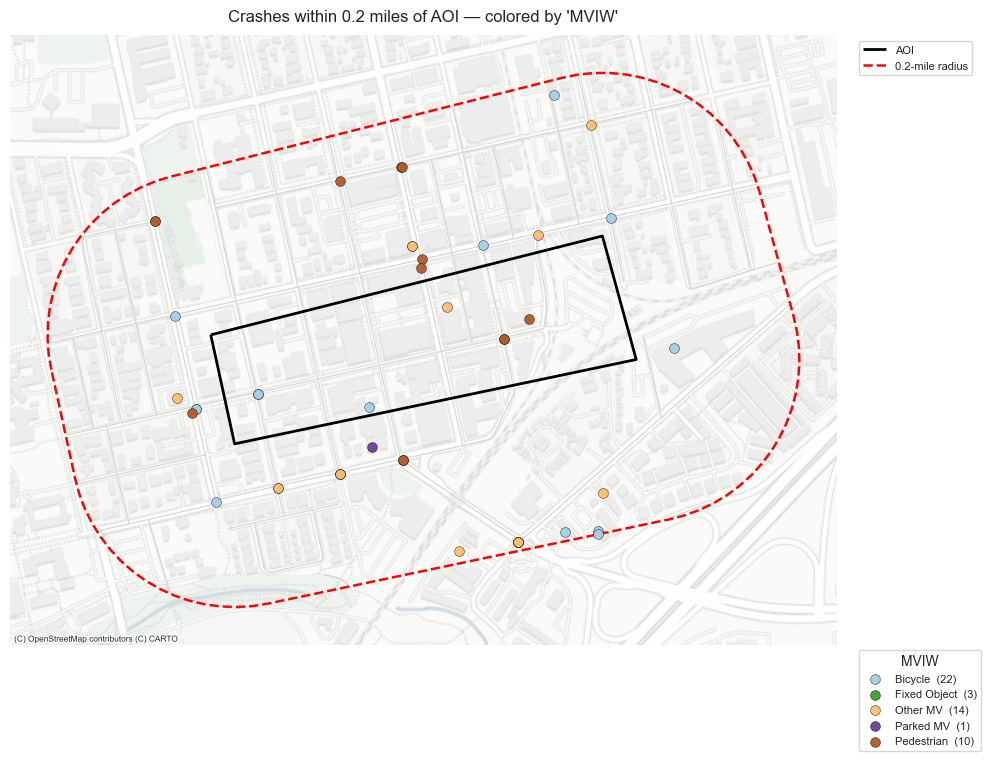

Crashes within 0.2 miles: 50
MVIW
G    22
C    14
B    10
I     3
E     1
Name: count, dtype: int64


In [8]:
# === Search for crashes within given radius and plot ===
search_radius = 0.20   # miles (change to whatever you want)
lbl = radius_label(search_radius)
category_col  = "MVIW"

# --- Run analysis + plot ---
crashes_in_radius = plot_crashes_by_category(
    crashes_df=crash_gdf,    # your TIMS data
    aoi_gdf=aoi,             # AOI polygon
    category_col=category_col,
    radius_miles=search_radius,
    filter_i80=True,         # exclude I-80 and ramps
    centerlines_gdf=davis_gdf,
    save_path=f"figures/crashes_by_{category_col.lower()}_{lbl}mi.png",
)

# Quick summary 
print(f"Crashes within {search_radius} miles: {len(crashes_in_radius)}")
print(crashes_in_radius[category_col].value_counts().head())

# Save filtered subset for GIS / later analysis
crashes_in_radius.to_file(f"outputs/crashes_within_{lbl}mi.geojson", driver="GeoJSON")

# Export category counts as CSV
(crashes_in_radius[category_col]
 .value_counts()
 .rename_axis(category_col)
 .reset_index(name="count")
 .to_csv(f"outputs/counts_{category_col.lower()}_{lbl}mi.csv", index=False))

### Crashes within n-Mile EDA

In [9]:
df = crashes_in_radius.copy()

cols_of_interest = [
    "COLLISION_SEVERITY",   # crash outcome
    "TYPE_OF_COLLISION",    # how
    "PRIMARY_COLL_FACTOR",  # why
    "WEATHER_1",            # conditions
    "LIGHTING",             # visibility
    "DAY_OF_WEEK",          # temporal
]
df = df[cols_of_interest].fillna("Unknown")
day_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
if df["DAY_OF_WEEK"].dtype != "O":  # numeric days
    day_map = {1:"Sunday",2:"Monday",3:"Tuesday",4:"Wednesday",5:"Thursday",6:"Friday",7:"Saturday"}
    df["DAY_OF_WEEK"] = df["DAY_OF_WEEK"].map(day_map)
else:
    df["DAY_OF_WEEK"] = pd.Categorical(df["DAY_OF_WEEK"], categories=day_order, ordered=True)

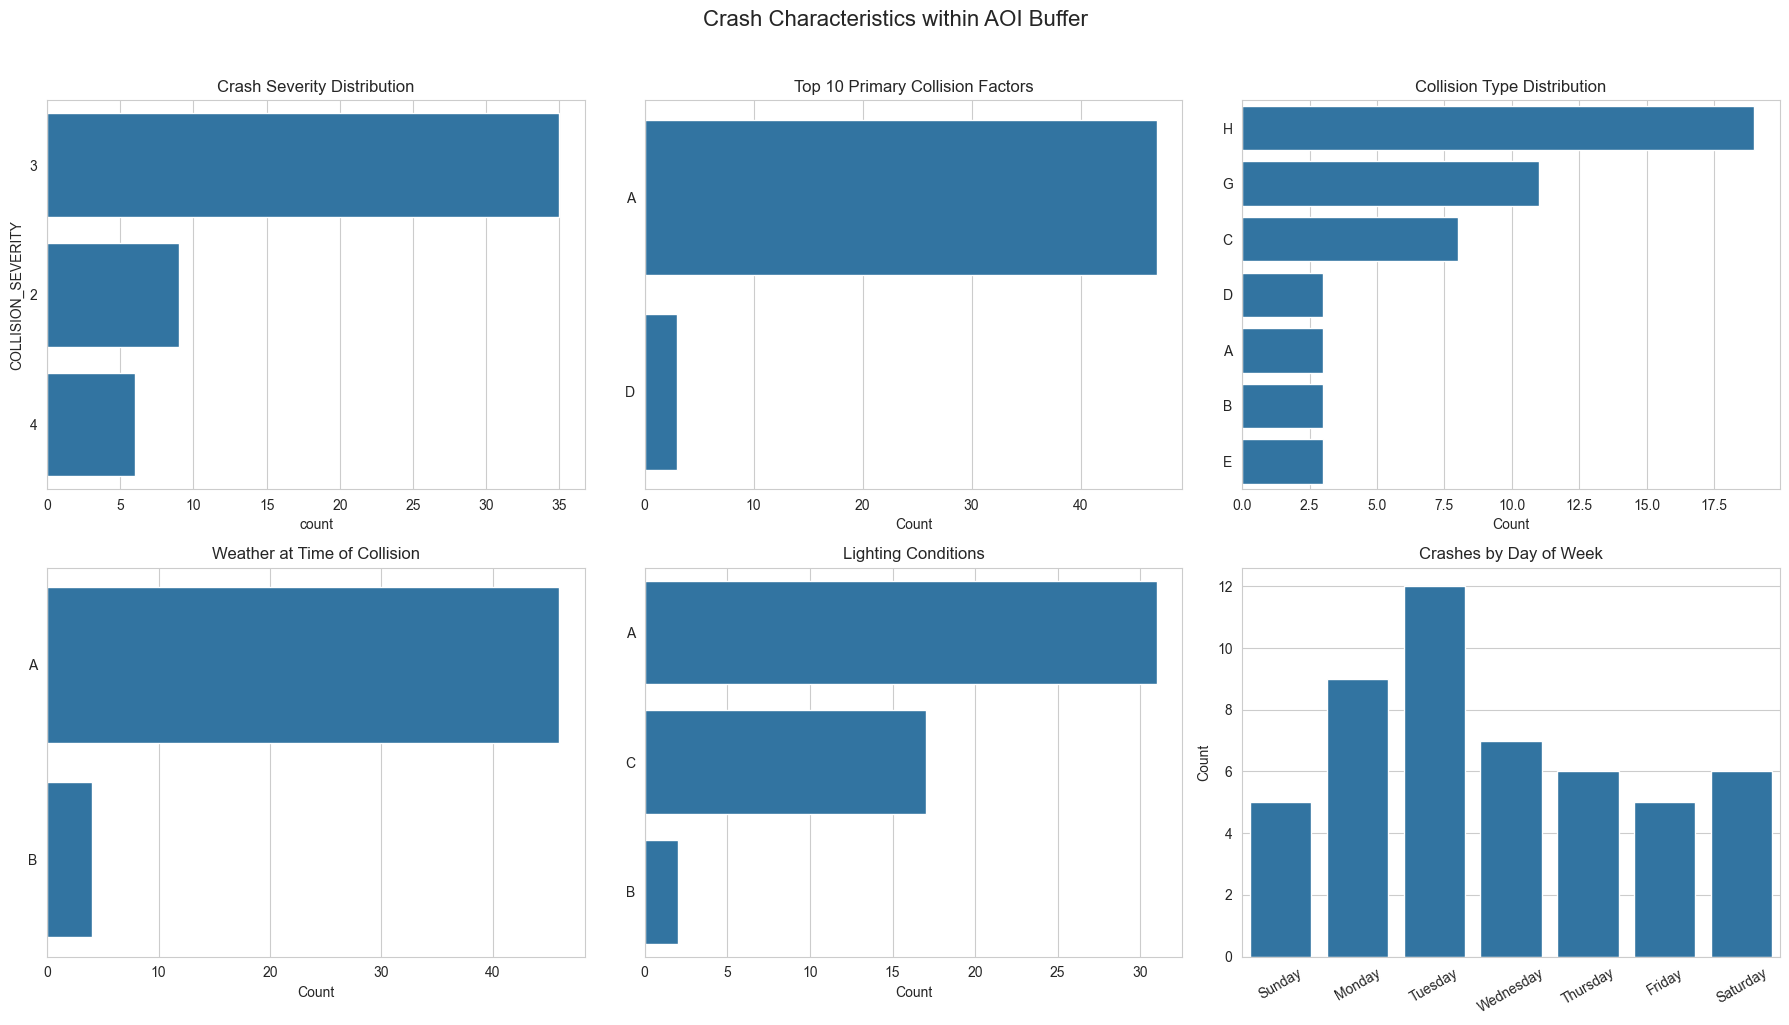

In [11]:
# --- Create subplots ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Severity distribution
sns.countplot(y="COLLISION_SEVERITY", data=df, order=df["COLLISION_SEVERITY"].value_counts().index, ax=axes[0])
axes[0].set_title("Crash Severity Distribution")

# Primary collision factor (top 10)
top_factors = df["PRIMARY_COLL_FACTOR"].value_counts().nlargest(10)
sns.barplot(y=top_factors.index, x=top_factors.values, ax=axes[1])
axes[1].set_title("Top 10 Primary Collision Factors")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")

# Type of collision
top_types = df["TYPE_OF_COLLISION"].value_counts()
sns.barplot(y=top_types.index, x=top_types.values, ax=axes[2])
axes[2].set_title("Collision Type Distribution")
axes[2].set_xlabel("Count")
axes[2].set_ylabel("")

# Weather conditions
top_weather = df["WEATHER_1"].value_counts()
sns.barplot(y=top_weather.index, x=top_weather.values, ax=axes[3])
axes[3].set_title("Weather at Time of Collision")
axes[3].set_xlabel("Count")
axes[3].set_ylabel("")

# Lighting conditions
top_light = df["LIGHTING"].value_counts()
sns.barplot(y=top_light.index, x=top_light.values, ax=axes[4])
axes[4].set_title("Lighting Conditions")
axes[4].set_xlabel("Count")
axes[4].set_ylabel("")

# Crashes by day of week
sns.countplot(x="DAY_OF_WEEK", data=df, order=day_order, ax=axes[5])
axes[5].set_title("Crashes by Day of Week")
axes[5].set_xlabel("")
axes[5].set_ylabel("Count")
for tick in axes[5].get_xticklabels():
    tick.set_rotation(30)

# --- Final layout ---
fig.suptitle("Crash Characteristics within AOI Buffer", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()